In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# 自定义数据集
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None,mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = os.listdir(images_dir)
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        image_extension = os.path.splitext(self.images[idx])[1]
        mask_name = os.path.join(self.masks_dir, self.images[idx].replace(image_extension, '.png'))
        mask = Image.open(mask_name).convert("L")
        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask)
        return image, mask.squeeze(0)

In [3]:
# 数据预处理 和 数据增强 随机旋转、翻转、缩放和颜色抖动
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Nearest to keep class values intact
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Nearest to keep class values intact
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))
])

# 加载数据集
# 划分数据集为训练集和测试集
train_dataset = SegmentationDataset('deeplabv3/train/', 'deeplabv3/masks/train/', transform=transform, mask_transform=mask_transform)
val_dataset = SegmentationDataset('deeplabv3/val/', 'deeplabv3/masks/val/', transform=transform, mask_transform=mask_transform)
# test_dataset = SegmentationDataset('deeplabv3/test/', 'deeplabv3/masks/test1/', transform=transform, mask_transform=mask_transform)
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 加载 DeepLabV3 模型
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
num_classes = 4  # 根据您的类别数调整
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)  # 替换分类层 
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')  # 使用 GPU 或 CPU



# 训练设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 改进了权重 更加重视代表性不足的类
weights = torch.tensor([0.5, 1.5, 2.5, 3.0], dtype=torch.float32).to(device)  
criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\SoftWare\Anaconda3\envs\COMP9444PRO\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# 训练循环
num_epochs = 5  # 根据需要设置训练轮数
class_pixel_count = np.zeros(num_classes)  # Initialize class pixel count
for epoch in range(num_epochs):
    model.train()  # 训练模型
    for images, masks in train_loader:
        
        images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
        masks = masks.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # for cls in range(num_classes):
        #     class_pixel_count[cls] += (masks == cls).sum().item()  # Count pixels for each class
        #     print(f"Batch pixel count for class {cls}: {(masks == cls).sum().item()}")
        # 清空梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(images)['out']
        
        # 计算损失
        loss = criterion(outputs, masks.long())  # 确保 mask 是 long 类型
        
        # 反向传播
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        torch.save(model.state_dict(), f'deeplabv3_model{epoch}.pth')
print("Training complete. Model saved.")

Epoch [1/5], Loss: 1.4518
Epoch [1/5], Loss: 1.2521
Epoch [1/5], Loss: 1.1931
Epoch [1/5], Loss: 0.9953
Epoch [1/5], Loss: 1.1411
Epoch [1/5], Loss: 0.9173
Epoch [1/5], Loss: 0.9580
Epoch [1/5], Loss: 0.9441
Epoch [1/5], Loss: 0.8539
Epoch [1/5], Loss: 0.8960
Epoch [1/5], Loss: 0.8090
Epoch [1/5], Loss: 0.7281
Epoch [1/5], Loss: 0.7921
Epoch [1/5], Loss: 0.6970
Epoch [1/5], Loss: 0.6724
Epoch [1/5], Loss: 0.7250
Epoch [1/5], Loss: 0.5466
Epoch [1/5], Loss: 0.6752
Epoch [1/5], Loss: 0.6933
Epoch [1/5], Loss: 0.9887
Epoch [1/5], Loss: 0.8178


KeyboardInterrupt: 

In [14]:
#载入训练好的模型
model = torchvision.models.segmentation.__dict__["deeplabv3_resnet101"](aux_loss=True, num_classes=4)
checkpoint = torch.load("checkpoint5.pth", map_location="cpu")
# model.load_state_dict(checkpoint, strict=False)
model.load_state_dict({k: v for k, v in checkpoint.items() if 'aux_classifier' not in k}, strict=False)
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    model.to('cuda')
model.eval()

C:\Users\ljk\AppData\Local\Temp\ipykernel_9712\3973553754.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint5.pth", map_location="cpu")


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [16]:
def calculate_metrics(predictions, masks, num_classes):
    metrics = {
        'iou': np.zeros(num_classes),
        'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
    }

    # Calculate IoU per class
    for cls in range(num_classes):
        pred_mask = (predictions == cls).astype(np.uint8)
        true_mask = (masks == cls).astype(np.uint8)
        
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        
        if union > 0:
            metrics['iou'][cls] = intersection / union  # IoU for each class

    metrics['confusion_matrix'] = confusion_matrix(masks.flatten(), predictions.flatten(), labels=range(num_classes))
    return metrics


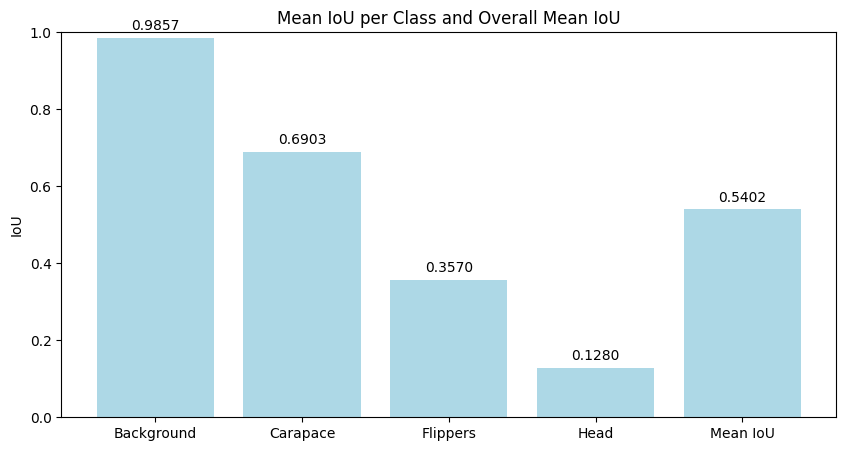

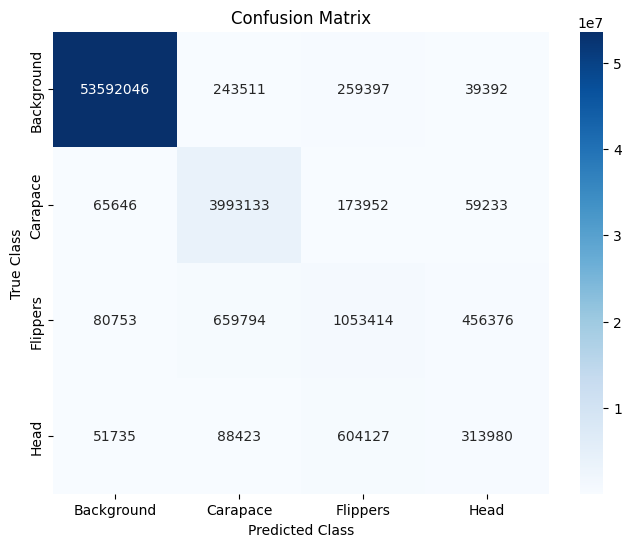

In [15]:
# Set model to evaluation mode
model.eval()

# Initialize arrays to store cumulative metrics across all images in the validation set
all_metrics = {
    'iou': [],
    'confusion_matrix': np.zeros((num_classes, num_classes), dtype=int)
}

# Evaluate model without computing gradients
with torch.no_grad():
    for images, masks in val_loader:  # Assuming val_loader is your validation DataLoader
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Move images and masks to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass to get predictions
        outputs = model(images)['out']
        predictions = outputs.argmax(dim=1).cpu().numpy()  # Convert predictions to numpy
        true_masks = masks.cpu().numpy()  # Convert ground truth to numpy
        
        # Calculate metrics for each image in the batch
        for pred, true_mask in zip(predictions, true_masks):
            
            metrics = calculate_metrics(pred, true_mask, num_classes)
            all_metrics['iou'].append(metrics['iou'])  # Append per-image IoU
            all_metrics['confusion_matrix'] += metrics['confusion_matrix']  # Add to cumulative confusion matrix

# Aggregate IoU results across the dataset
mean_iou_per_class = np.nanmean(np.vstack(all_metrics['iou']), axis=0)  # Mean IoU per class
overall_mean_iou = np.nanmean(mean_iou_per_class)  # Overall mean IoU across classes
confusion_matrix_total = all_metrics['confusion_matrix']

# Plot IoU per Class and Overall Mean IoU
class_labels = ["Background", "Carapace", "Flippers", "Head"]
plt.figure(figsize=(10, 5))
plt.bar(class_labels + ["Mean IoU"], np.append(mean_iou_per_class, overall_mean_iou), color='lightblue')
plt.ylim(0, 1)
plt.ylabel("IoU")
plt.title("Mean IoU per Class and Overall Mean IoU")
for i, v in enumerate(np.append(mean_iou_per_class, overall_mean_iou)):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_total, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


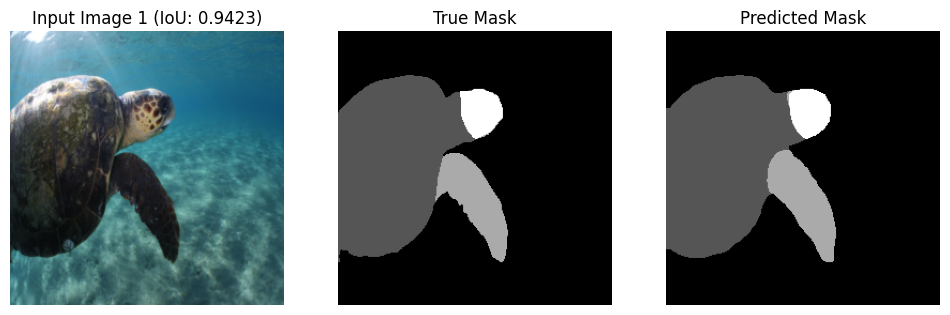

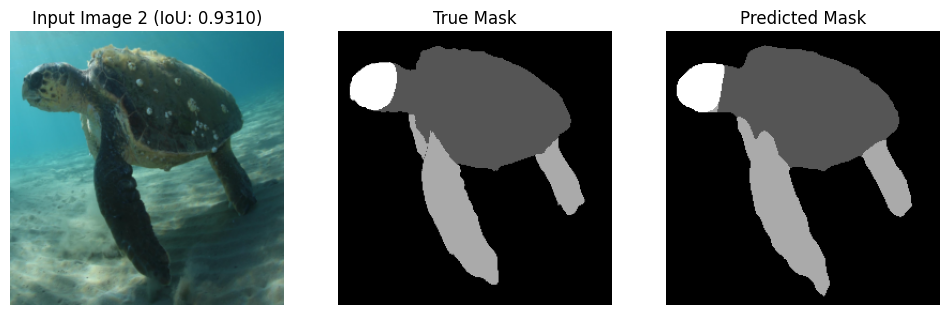

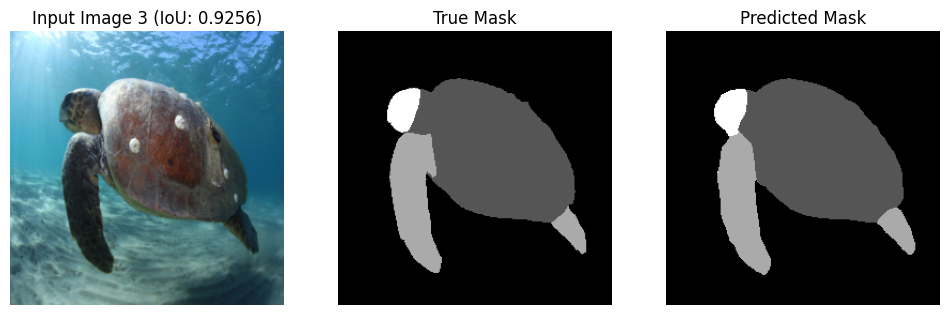

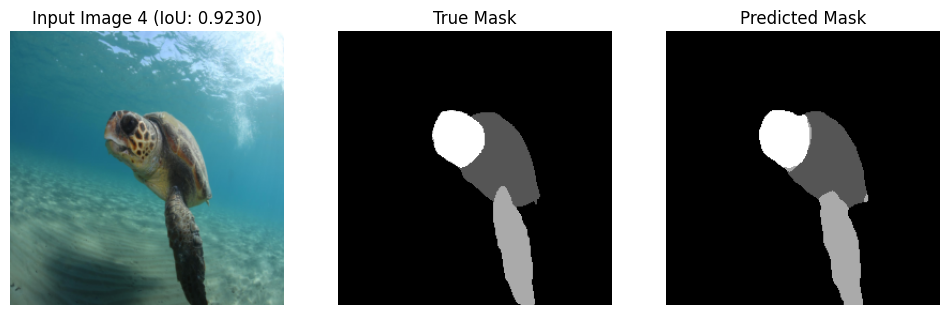

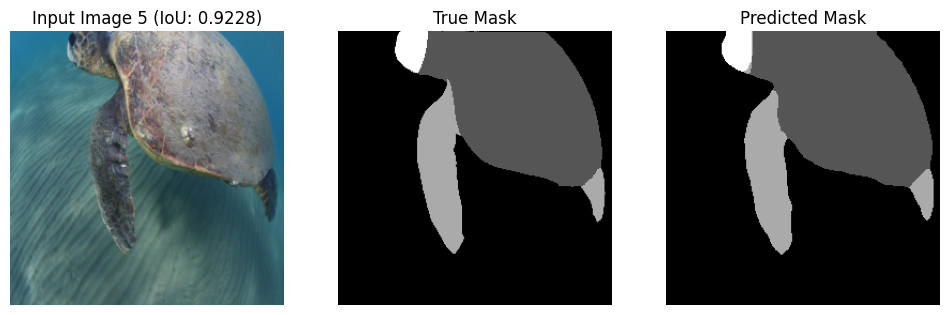

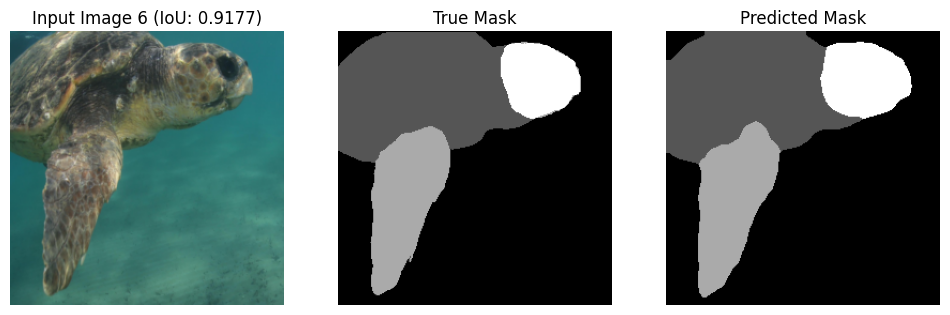

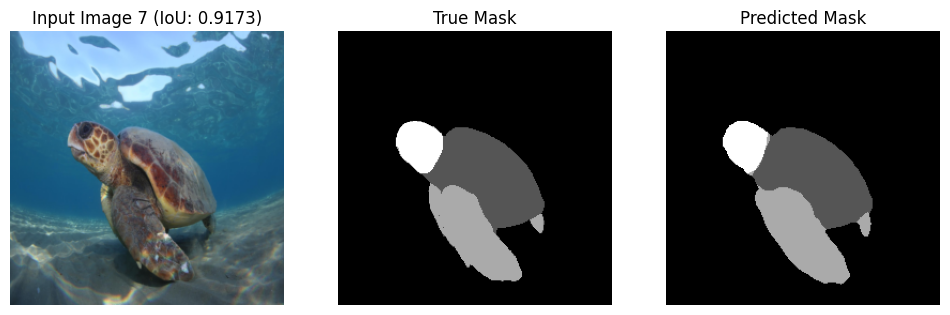

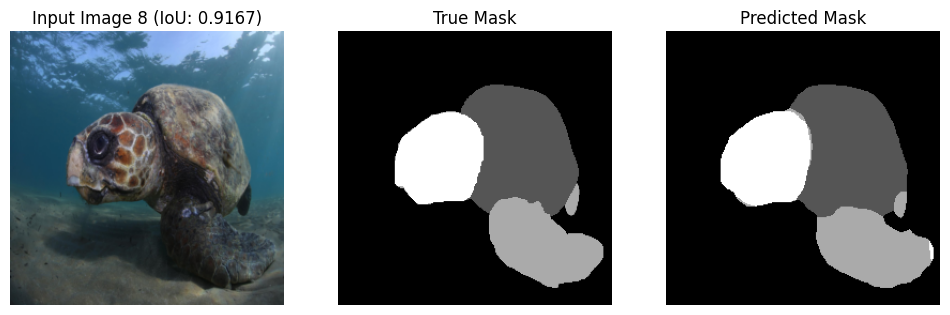

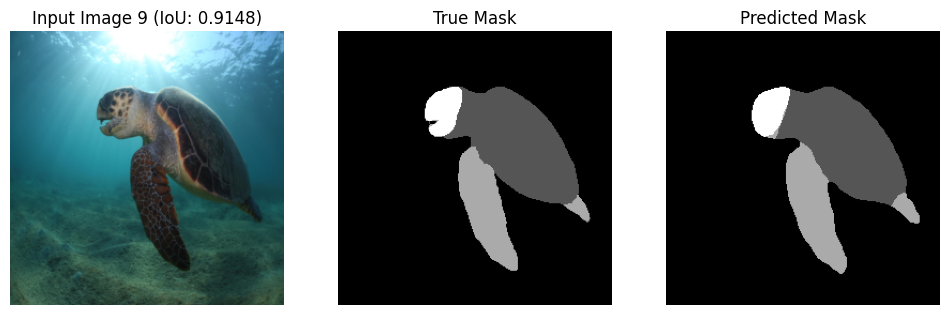

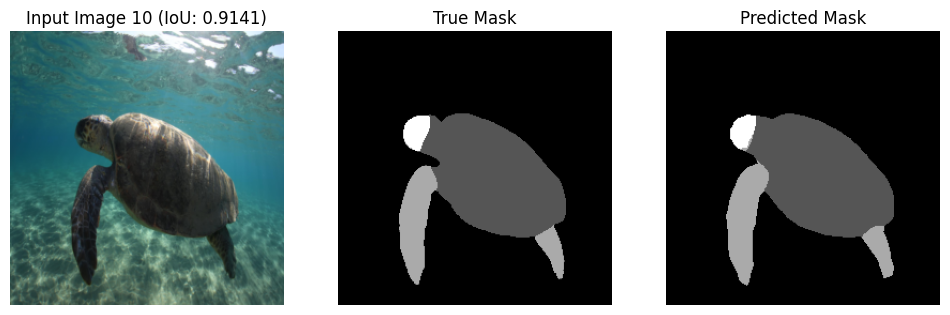

In [17]:
def calculate_iou(prediction, mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_mask = (prediction == cls).astype(np.uint8)
        true_mask = (mask == cls).astype(np.uint8)
        
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()
        
        if union == 0:
            ious.append(np.nan)  # Ignore if there is no true or predicted pixels for this class
        else:
            ious.append(intersection / union)
    
    return np.nanmean(ious)  # Mean IoU for the image

def visualize_top_iou_predictions(model, data_loader, num_classes, top_k=10):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    iou_scores = []
    images_list = []
    masks_list = []
    predictions_list = []
    
    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Get model predictions
            outputs = model(images)['out']
            predictions = outputs.argmax(dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            
            # Calculate IoU for each image in the batch
            for i in range(images.size(0)):
                iou = calculate_iou(predictions[i], masks[i], num_classes)
                iou_scores.append((iou, images[i].cpu(), masks[i], predictions[i]))
    
    # Sort by IoU and select the top-k
    iou_scores.sort(reverse=True, key=lambda x: x[0])  # Sort by IoU score in descending order
    top_k_images = iou_scores[:top_k]
    
    # Visualize the top-k images
    for idx, (iou, image, mask, prediction) in enumerate(top_k_images, 1):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Input Image {idx} (IoU: {iou:.4f})")
        plt.imshow(image.permute(1, 2, 0))  # Convert to HWC format
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(prediction, cmap='gray')
        plt.axis('off')

        plt.show()

# Visualize the top 10 images by IoU
visualize_top_iou_predictions(model, val_loader, num_classes, top_k=10)